In [41]:
import pandas as pd
"""
Imports necessary libraries and modules for logistic regression analysis.

Modules:
- pandas as pd: Used for data manipulation and analysis.
- numpy as np: Used for numerical operations.
- sklearn.linear_model.LogisticRegression: Used to perform logistic regression.
- sklearn.preprocessing.StandardScaler: Used to standardize features by removing the mean and scaling to unit variance.
- sklearn.metrics.confusion_matrix: Used to compute confusion matrix to evaluate the accuracy of a classification.
- sklearn.metrics.accuracy_score: Used to compute the accuracy classification score.
- sklearn.metrics.classification_report: Used to build a text report showing the main classification metrics.
- sklearn.model_selection.cross_val_score: Used to evaluate a score by cross-validation.
"""
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


In [42]:
# ladataan data ja poistetaan duplikaatit ja tyhjät

df = pd.read_csv('Loan_Data.csv', sep=',').drop_duplicates().dropna()

# poistetaan ID
df = df.drop(columns=['Loan_ID'])
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             480 non-null    object 
 1   Married            480 non-null    object 
 2   Dependents         480 non-null    object 
 3   Education          480 non-null    object 
 4   Self_Employed      480 non-null    object 
 5   ApplicantIncome    480 non-null    int64  
 6   CoapplicantIncome  480 non-null    float64
 7   LoanAmount         480 non-null    float64
 8   Loan_Amount_Term   480 non-null    float64
 9   Credit_History     480 non-null    float64
 10  Property_Area      480 non-null    object 
 11  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 48.8+ KB


In [44]:
# muutetaan tekstit 0/1
df['Gender'] = df['Gender'].replace(['Male', 'Female'], [1, 2])
df['Married'] = df['Married'].replace(['No', 'Yes'], [0, 1])
df['Education'] = df['Education'].replace(['Not Graduate', 'Graduate'], [0, 1])
df['Self_Employed'] = df['Self_Employed'].replace(['No', 'Yes'], [0, 1])
df['Dependents'] = df['Dependents'].replace(['0', '1', '2', '3+'], [0,1,2,3])
df['Loan_Status'] = df['Loan_Status'].replace(['N', 'Y'], [0, 1])


U:\Users\jk026110\AppData\Local\Temp\ipykernel_10772\426804542.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace(['Male', 'Female'], [1, 2])
U:\Users\jk026110\AppData\Local\Temp\ipykernel_10772\426804542.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Married'] = df['Married'].replace(['No', 'Yes'], [0, 1])
U:\Users\jk026110\AppData\Local\Temp\ipykernel_10772\426804542.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retai

In [45]:
dummies = pd.get_dummies(df['Property_Area'], drop_first=False)
dummies = dummies.astype(int)

In [46]:
# lisätään alueet dataframeen ja pudotetaan alkuperäinen Property_Area pois
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['Property_Area'])
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Rural,Semiurban,Urban
1,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,0,1,0,0
2,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,1,0,0,1
3,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,1,0,0,1
4,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,1,0,0,1
5,1,1,2,1,1,5417,4196.0,267.0,360.0,1.0,1,0,0,1


In [47]:
# vastemuuttujan jakauma
df['Loan_Status'].value_counts()

Loan_Status
1    332
0    148
Name: count, dtype: int64

In [48]:
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Rural',
       'Semiurban', 'Urban'],
      dtype='object')

In [49]:
# selittävät muuttujat
X = df.loc[:,['Gender', 'Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount',
'Loan_Amount_Term','Credit_History','Rural','Semiurban','Urban']]

#vastemuuttuja
Y= df.loc[:,'Loan_Status']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(360, 13)
(360,)
(120, 13)
(120,)


TypeError: 'NoneType' object is not subscriptable

In [51]:
# skaalataan x_train
scaler = StandardScaler().fit(x_train)
scaler

leveys = len(max(df.columns, key=len))

# Tulostetaan mean ja scale käyttämättä eksponenttimuotoa
np.set_printoptions(suppress=True)

print("mean:")
for col, mean in zip(df.columns, scaler.mean_):
    print(f"{col:.<{leveys+1}} {mean:.2f}")

print("\nscale:")
for col, scale in zip(df.columns, scaler.scale_):
    print(f"{col:.<{leveys+1}} {scale:.2f}")
print(f"scale: {scaler.scale_}")

mean:
Gender............ 1.19
Married........... 0.66
Dependents........ 0.76
Education......... 0.80
Self_Employed..... 0.15
ApplicantIncome... 5331.22
CoapplicantIncome. 1656.56
LoanAmount........ 143.46
Loan_Amount_Term.. 342.90
Credit_History.... 0.84
Loan_Status....... 0.28
Rural............. 0.40
Semiurban......... 0.32

scale:
Gender............ 0.39
Married........... 0.47
Dependents........ 1.00
Education......... 0.40
Self_Employed..... 0.36
ApplicantIncome... 6001.41
CoapplicantIncome. 2855.68
LoanAmount........ 79.63
Loan_Amount_Term.. 63.42
Credit_History.... 0.36
Loan_Status....... 0.45
Rural............. 0.49
Semiurban......... 0.47
scale: [   0.39142033    0.47426844    0.99851356    0.4           0.35707142
 6001.41205043 2855.67672819   79.63188668   63.42231468    0.36243348
    0.44927067    0.49045677    0.46517619]


In [52]:
x_scaled = scaler.transform(x_train)
print('scaled', x_scaled)

print('mean', x_scaled.mean(axis=0))
print('std', x_scaled.std(axis=0))

scaled [[-0.48257301 -1.38810276 -0.76502606 ... -0.62446889 -0.82122993
   1.46897745]
 [-0.48257301  0.72040776  1.23795126 ...  1.60136081 -0.82122993
  -0.68074565]
 [-0.48257301  0.72040776 -0.76502606 ... -0.62446889 -0.82122993
   1.46897745]
 ...
 [-0.48257301  0.72040776 -0.76502606 ...  1.60136081 -0.82122993
  -0.68074565]
 [ 2.07222529  0.72040776 -0.76502606 ... -0.62446889  1.21768576
  -0.68074565]
 [-0.48257301 -1.38810276 -0.76502606 ... -0.62446889  1.21768576
  -0.68074565]]
mean [ 0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0.]
std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [53]:
# tehdään malli ja sovitetaan data
reg = LogisticRegression()
reg.fit(x_scaled, y_train)


LogisticRegression()

In [54]:
# print("Coefficients: ",reg.coef_)
# print("Intercept: ", reg.intercept_)

print("Coefficients:")
for col, coef in zip(X.columns, reg.coef_[0]):
    print(f"{col:<{leveys+1}} {coef: .2f}")

print(f"\nIntercept {reg.intercept_[0].round(2)}")

Coefficients:
Gender             -0.05
Married             0.30
Dependents          0.05
Education           0.15
Self_Employed      -0.10
ApplicantIncome     0.04
CoapplicantIncome  -0.14
LoanAmount         -0.15
Loan_Amount_Term   -0.03
Credit_History      1.31
Rural              -0.14
Semiurban           0.30
Urban              -0.19

Intercept 0.8


ylivoimaisesti suurin vaikutus on Credit_History:lla

In [55]:
# skaalataan x_test
scaler2 = StandardScaler().fit(x_test)

leveys = len(max(df.columns, key=len))

# Tulostetaan mean ja scale käyttämättä eksponenttimuotoa
np.set_printoptions(suppress=True)

print("mean:")
for col, mean in zip(df.columns, scaler2.mean_):
    print(f"{col:.<{leveys}}  {mean:.2f}")

print("\nscale:")
for col, scale in zip(df.columns, scaler2.scale_):
    print(f"{col:.<{leveys}}  {scale:.2f}")



mean:
Gender...........  1.15
Married..........  0.62
Dependents.......  0.82
Education........  0.79
Self_Employed....  0.10
ApplicantIncome..  5463.27
CoapplicantIncome  1354.70
LoanAmount.......  148.56
Loan_Amount_Term.  339.50
Credit_History...  0.88
Loan_Status......  0.32
Rural............  0.38
Semiurban........  0.30

scale:
Gender...........  0.36
Married..........  0.49
Dependents.......  1.08
Education........  0.41
Self_Employed....  0.30
ApplicantIncome..  4492.73
CoapplicantIncome  1679.03
LoanAmount.......  82.64
Loan_Amount_Term.  70.00
Credit_History...  0.32
Loan_Status......  0.47
Rural............  0.49
Semiurban........  0.46


In [56]:
x_test_scaled = scaler2.transform(x_test)
print('scaled', x_test_scaled)
#print(f"mean: {x_test_scaled.mean(axis=0)}")
#print(f"mean: {x_test_scaled.std(axis=0)}")


# print("scaled:")
# for col, value in zip(X.columns, x_test_scaled.T):
#     print(f"{col:.<{leveys+1}} {value.mean():.4f}")



scaled [[-0.42008403 -1.26834366  1.09568423 ...  1.46897745 -0.78842985
  -0.65465367]
 [-0.42008403  0.78842985 -0.75617644 ... -0.68074565  1.26834366
  -0.65465367]
 [-0.42008403  0.78842985  2.02161457 ... -0.68074565  1.26834366
  -0.65465367]
 ...
 [-0.42008403  0.78842985 -0.75617644 ... -0.68074565  1.26834366
  -0.65465367]
 [-0.42008403 -1.26834366 -0.75617644 ... -0.68074565 -0.78842985
   1.52752523]
 [-0.42008403  0.78842985  2.02161457 ... -0.68074565  1.26834366
  -0.65465367]]


In [57]:
# lasketaan mallin ennusteet
y_pred = reg.predict(x_test_scaled)
print(f"y_pred: {y_pred.shape}")
print(f"y_test: {y_test.shape}")

y_pred: (120,)
y_test: (120,)


In [58]:
# mallin arviointi
cm = confusion_matrix(y_test, y_pred)
print(f"Sekaannusmatriisi:\n{cm}")

accuracy=accuracy_score(y_test, y_pred)
print(f"\nTarkkuus (laskettu koulutusdatasta): {accuracy}\n")
print(classification_report(y_test, y_pred))

Sekaannusmatriisi:
[[12 19]
 [ 2 87]]

Tarkkuus (laskettu koulutusdatasta): 0.825

              precision    recall  f1-score   support

           0       0.86      0.39      0.53        31
           1       0.82      0.98      0.89        89

    accuracy                           0.82       120
   macro avg       0.84      0.68      0.71       120
weighted avg       0.83      0.82      0.80       120



In [59]:
# ristiinvalidointi
k = 5
scores = cross_val_score(estimator=reg,
                         X=x_scaled,
                         y=y_train,
                         scoring="accuracy",
                         cv=k)
print(f"Tarkkuudet {k} kierrokselta:")
print(scores.round(2))
print(f"Tarkkuus laskettuna käyttäen {k}-kertaista ristiinvalidointia: {scores.mean().round(2)}")

Tarkkuudet 5 kierrokselta:
[0.74 0.82 0.82 0.78 0.81]
Tarkkuus laskettuna käyttäen 5-kertaista ristiinvalidointia: 0.79


In [60]:
# mallin analysointi
cof_data=pd.DataFrame(reg.coef_*100, columns = x_test.columns).T
cof_data[0].sort_values(ascending=False)

Credit_History       130.918952
Semiurban             30.356149
Married               30.243490
Education             14.733865
Dependents             4.798168
ApplicantIncome        3.654176
Loan_Amount_Term      -2.933189
Gender                -4.973823
Self_Employed        -10.011787
CoapplicantIncome    -13.646934
Rural                -13.819622
LoanAmount           -15.437677
Urban                -18.658796
Name: 0, dtype: float64

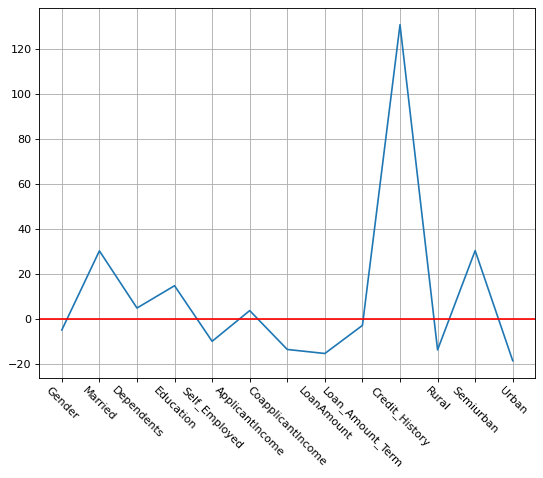

In [61]:
# kulmakertoimet
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=80)
plt.plot(cof_data)
plt.xticks(rotation=-45)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid()
plt.show()


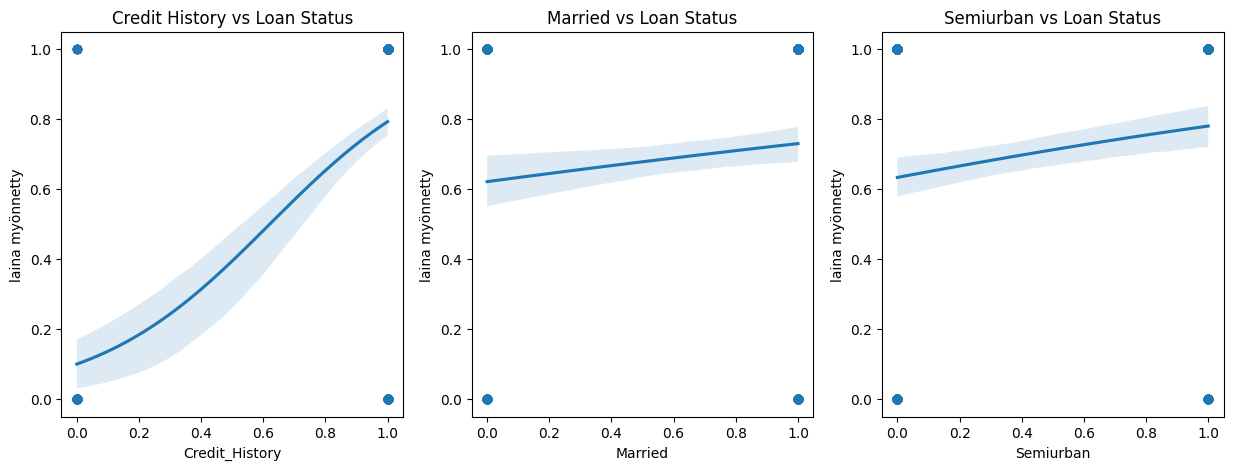

In [62]:
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df["Credit_History"], y=df["Loan_Status"].eq(1).rename("laina myönnetty"), logistic=True, ax=axes[0])
axes[0].set_title('Credit History vs Loan Status')

sns.regplot(x=df["Married"], y=df["Loan_Status"].eq(1).rename("laina myönnetty"), logistic=True, ax=axes[1])
axes[1].set_title('Married vs Loan Status')

sns.regplot(x=df["Semiurban"], y=df["Loan_Status"].eq(1).rename("laina myönnetty"), logistic=True, ax=axes[2])
axes[2].set_title('Semiurban vs Loan Status')

plt.show()


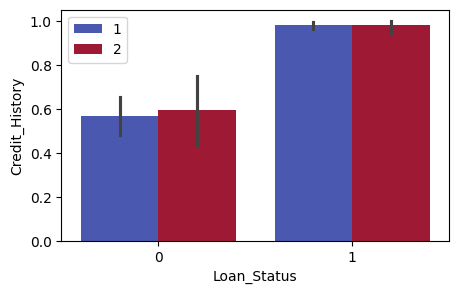

In [63]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x='Loan_Status', y='Credit_History', hue='Gender', data=df, ax=ax, palette='coolwarm')

plt.legend(loc='upper left', prop={'size': 10})
plt.show()

In [64]:
# miehiä on paljon enemmän
df['Gender'].value_counts()

Gender
1    394
2     86
Name: count, dtype: int64

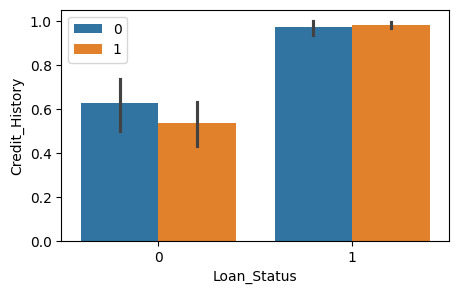

In [65]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x='Loan_Status', y='Credit_History', hue='Married', data=df, ax=ax)

plt.legend(loc='upper left', prop={'size': 10})
plt.show()

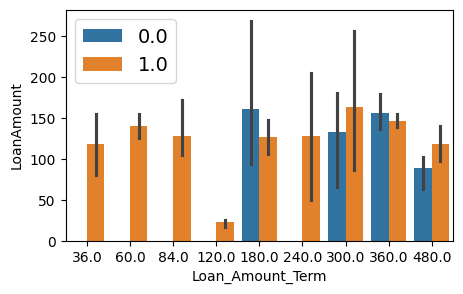

In [66]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x='Loan_Amount_Term', y='LoanAmount', hue='Credit_History', data=df, ax=ax)
plt.legend(loc='upper left', prop={'size': 14})
plt.show()

In [67]:
# ennustaminen
proba = reg.predict_proba(x_test_scaled).round(2)
proba

array([[0.96, 0.04],
       [0.09, 0.91],
       [0.11, 0.89],
       [0.32, 0.68],
       [0.36, 0.64],
       [0.88, 0.12],
       [0.21, 0.79],
       [0.26, 0.74],
       [0.27, 0.73],
       [0.29, 0.71],
       [0.91, 0.09],
       [0.16, 0.84],
       [0.24, 0.76],
       [0.21, 0.79],
       [0.94, 0.06],
       [0.12, 0.88],
       [0.21, 0.79],
       [0.18, 0.82],
       [0.26, 0.74],
       [0.16, 0.84],
       [0.13, 0.87],
       [0.3 , 0.7 ],
       [0.17, 0.83],
       [0.31, 0.69],
       [0.25, 0.75],
       [0.38, 0.62],
       [0.14, 0.86],
       [0.32, 0.68],
       [0.94, 0.06],
       [0.3 , 0.7 ],
       [0.13, 0.87],
       [0.32, 0.68],
       [0.22, 0.78],
       [0.22, 0.78],
       [0.35, 0.65],
       [0.12, 0.88],
       [0.15, 0.85],
       [0.08, 0.92],
       [0.11, 0.89],
       [0.36, 0.64],
       [0.2 , 0.8 ],
       [0.13, 0.87],
       [0.31, 0.69],
       [0.19, 0.81],
       [0.24, 0.76],
       [0.31, 0.69],
       [0.26, 0.74],
       [0.37,

In [68]:
#log loss, keskiarvo kaikista log loss arvoista
#tulisi olla mahdollisimman lähellä nollaa ja välillä 0-1
#voidaan käyttää vain binaariseen dataan
from sklearn.metrics import log_loss
logloss = log_loss(y_test, proba)
logloss

0.4672000385415514

In [73]:
# kuvannetaan ennusteet

# proba.round(2)[:96]

# fig, ax = plt.subplots(figsize= (20,70))
# im = ax.imshow(proba, cmap='Blues')

# ax.grid(axis='y')
# ax.set_xticklabels([])

# ax.set_yticks(np.arange(proba.shape[0]))

# plt.ylabel('Havainnot', fontsize='xx-large')
# plt.xlabel('Luokat', fontsize='xx-large', loc='center')
# fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) 

# for i in range(proba.shape[0]):
#     for j in range(2):
#         if proba[i, j] >.5:
#              ax.text(j, i, j,
#                      ha="center", va="center", color="r", fontsize=15)